In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean


df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)

df['AWS2'] = df['AWS']

features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['doy']  = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2 * np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2 * np.pi * df['doy']  / 365)


In [3]:
split_time = pd.Timestamp('2020-10-15 23:00:00')
df_train = df[df['datetime'] <= split_time].reset_index(drop=True)
df_test  = df[df['datetime'] >  split_time].reset_index(drop=True)

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features]  = scaler.transform(df_test[features])


In [4]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    times = data['datetime'].tolist()
    for i in range(window_size, len(data) - horizon + 1):
        if any((times[j] - times[j-1]).total_seconds() != 3600 
               for j in range(i-window_size+1, i+horizon)):
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


window_size = 1
horizon     = 6

X_train, y_train = make_sequences(df_train, features, target, window_size, horizon)
X_test,  y_test  = make_sequences(df_test,  features, target, window_size, horizon)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)


Train shapes: (351315, 1, 14) (351315, 6)
Test  shapes: (74038, 1, 14) (74038, 6)


C:\Users\Dell\AppData\Local\Temp\ipykernel_22056\3085696002.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from rs_lstm\lstm_rs\tuner0.json



c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters found:
  units1   = 128
  units2   = 64
  dropout1 = 0.30
  dropout2 = 0.20
  lr       = 0.0001
Epoch 1/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.1446 - mae: 0.1244 - val_loss: 0.2435 - val_mae: 0.1603
Epoch 2/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.1363 - mae: 0.1087 - val_loss: 0.2493 - val_mae: 0.1667
Epoch 3/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.1368 - mae: 0.1086 - val_loss: 0.2543 - val_mae: 0.1696
Epoch 4/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.1335 - mae: 0.1071 - val_loss: 0.2682 - val_mae: 0.1728
Epoch 5/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.1332 - mae: 0.1080 - val_loss: 0.2862 - val_mae: 0.1813
Epoch 6/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.1308 - mae: 0.1063 - val_loss: 0.2869 - val_mae: 0.1752
Epoch 7/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1312 - mae: 0.1065 - val_loss: 0.2935 - val_mae: 0.1788
Epoch 8/100
8783/8783 ━━━━━━━

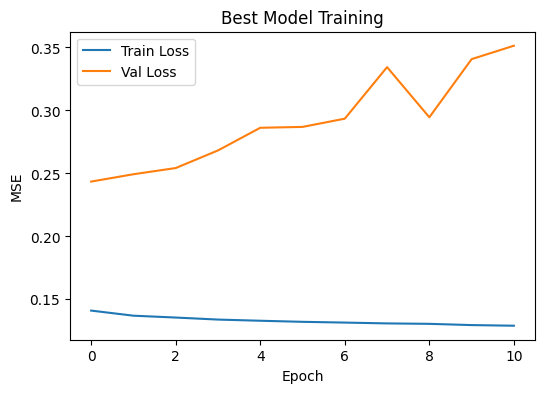

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


n_features = len(features)

def build_stacked_lstm(window_size, n_features, horizon,
                       units1, units2, dropout1, dropout2, lr):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    # Dense output
    model.add(Dense(horizon, activation='linear'))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


def build_model_hp(hp):
    return build_stacked_lstm(
        window_size=window_size,
        n_features=n_features,
        horizon=horizon,
        units1=hp.Choice('units1', [64, 128, 256]),
        units2=hp.Choice('units2', [32, 64, 128]),
        dropout1=hp.Float('dropout1', 0.1, 0.5, step=0.1),
        dropout2=hp.Float('dropout2', 0.1, 0.5, step=0.1),
        lr=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    )


tuner = RandomSearch(
    build_model_hp,
    objective='val_loss',    
    max_trials=20,             
    executions_per_trial=1,
    directory='rs_lstm',
    project_name='lstm_rs'
)


tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(f"  units1   = {best_hp.get('units1')}")
print(f"  units2   = {best_hp.get('units2')}")
print(f"  dropout1 = {best_hp.get('dropout1'):.2f}")
print(f"  dropout2 = {best_hp.get('dropout2'):.2f}")
print(f"  lr       = {best_hp.get('lr')}")

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ],
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training')
plt.legend()
plt.show()


In [8]:
best_model.save('best_model_2.h5')
print("Saved best_model to best_model.h5")

Saved best_model to best_model.h5


In [12]:
import tensorflow
loaded_model = tensorflow.keras.models.load_model('best_model_2.h5', custom_objects={'mse': tensorflow.keras.losses.MeanSquaredError})

In [14]:
from scipy.stats import pearsonr

y_pred = loaded_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R^2  : {r2:.4f}")

y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
print(f"Overall Pearson R: {pearson_r:.4f}")

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test MSE  : 0.3028
Test RMSE : 0.5503
Test MAE  : 0.2333
Test R^2  : 0.3250
Overall Pearson R: 0.5758


In [ ]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-04-15 00:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = best_model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
